In [1]:
import glob
import ast
import time
import numpy as np
import pandas as pd
from tqdm import tqdm 
import cv2
import json
import collections
from PIL import Image
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import zipfile

from tqdm import tqdm
import shutil

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Loading package

In [3]:
import sys
from pathlib import Path

here_path = Path().resolve()
repo_path = here_path.parents[1]
sys.path.append(str(repo_path))

In [4]:
from py.utils import verifyDir,verifyFile, verifyDataFrame

In [5]:
from py.config import Config

cfg = Config()

np.random.seed(cfg.RANDOM_STATE)
cfg.DATA_PATH, cfg.MODEL_PATH

('/media/felipe/DATA19/datasets/', '/media/felipe/DATA19/models/')

In [6]:
QSCORE_PATH=f"{cfg.DATA_PATH}pp2/{cfg.SCORING_METHOD}/{cfg.PLACE_LEVEL}/"
IMAGES_PATH = f"{cfg.DATA_PATH}pp2/images/"

FEATURES_PATH = f"{cfg.DATA_PATH}pp2/segmentations/{cfg.DATASET_SEG_NAME}/{cfg.MODEL_SEG_NAME}/"
MODEL_PATH = f"{cfg.MODEL_PATH}pp2/{cfg.ML_TYPE}/{cfg.SCORING_METHOD}/"

### Loading Data and Models

In [7]:
features_df = pd.read_csv(f"{FEATURES_PATH}segmentations.csv", sep=";", low_memory=False)
features_df = features_df.loc[:, (features_df != 0).any(axis=0)].copy()
feature_names = features_df.columns.tolist()
feature_names.remove("image_id")
features_df

,wall,building,sky,floor,tree,ceiling,road,windowpane,grass,sidewalk,...,tank,trade_name,pot,bicycle,sculpture,traffic_light,ashcan,pier,flag,image_id
0,0.000000,1.574167,42.730833,0.0,5.031667,0.0,36.835833,0.0,0.033333,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,513d677cfdc9f035870040af
1,0.232500,5.849167,8.832500,0.0,37.846667,0.0,31.366667,0.0,7.345000,3.849167,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,513d6c8ffdc9f03587004fcc
2,0.125833,21.213333,13.651667,0.0,15.863333,0.0,25.864167,0.0,0.789167,11.385833,...,0.0,0.0,1.377500,0.0,0.0,0.0,0.000,0.0,0.0,513d6b38fdc9f03587004c82
3,0.000000,0.015833,41.790833,0.0,16.505833,0.0,32.465000,0.0,0.000000,3.591667,...,0.0,0.0,0.193333,0.0,0.0,0.0,0.205,0.0,0.0,513d6bb6fdc9f03587004db0
4,0.199167,0.106667,6.445000,0.0,46.457500,0.0,13.627500,0.0,18.599167,9.519167,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,513d67a8fdc9f03587004125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296,0.000000,12.243333,37.321667,0.0,5.678333,0.0,31.678333,0.0,0.000000,0.475000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,513d6ba6fdc9f03587004d8e
1297,0.000000,38.336667,19.234167,0.0,0.928333,0.0,38.718333,0.0,1.423333,1.359167,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,513d686ffdc9f03587004385
1298,0.000000,44.598333,15.456667,0.0,1.174167,0.0,23.995000,0.0,0.000000,7.303333,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,513d6a2afdc9f0358700499f
1299,17.496667,0.057500,38.990833,0.0,7.129167,0.0,34.227500,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,513d6845fdc9f035870042f7


In [8]:
%%time
data_df = pd.read_csv(f"{QSCORE_PATH}scores.csv", sep=";", low_memory=False)
data_df["image_path"] = f"{IMAGES_PATH}" + data_df["image_path"]
data_df.sort_values(by=[cfg.PERCEPTION_METRIC], ascending=False, inplace=True)
data_df = pd.merge(data_df, features_df, how="inner", on=["image_id"])
data_df

CPU times: user 175 ms, sys: 42.3 ms, total: 217 ms
Wall time: 216 ms


,image_id,lat,long,city,country,continent,safety,beautiful,wealthy,lively,...,minibike,tank,trade_name,pot,bicycle,sculpture,traffic_light,ashcan,pier,flag
0,513d677cfdc9f035870040af,42.370774,-71.126977,Boston,USA,North America,8.583389,5.333333,6.055556,5.029020,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0
1,513d6c8ffdc9f03587004fcc,42.385246,-71.173652,Boston,USA,North America,8.222581,6.075926,5.277778,5.432792,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0
2,513d6b38fdc9f03587004c82,42.353972,-71.063971,Boston,USA,North America,8.016417,7.222222,7.500000,3.333333,...,0.0,0.0,0.0,1.377500,0.0,0.0,0.0,0.000,0.0,0.0
3,513d6bb6fdc9f03587004db0,42.315775,-71.034048,Boston,USA,North America,7.945597,5.303030,3.888889,7.810280,...,0.0,0.0,0.0,0.193333,0.0,0.0,0.0,0.205,0.0,0.0
4,513d67a8fdc9f03587004125,42.301764,-71.114991,Boston,USA,North America,7.918534,5.277778,6.333333,3.948302,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296,513d6ba6fdc9f03587004d8e,42.412917,-71.106858,Boston,USA,North America,1.764706,3.845679,2.777778,3.918651,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0
1297,513d6a2afdc9f0358700499f,42.374378,-71.119751,Boston,USA,North America,1.666667,5.611111,6.833333,6.494829,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0
1298,513d686ffdc9f03587004385,42.384908,-70.982451,Boston,USA,North America,1.666667,3.333333,1.666667,3.522727,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0
1299,513d6845fdc9f035870042f7,42.312479,-71.052465,Boston,USA,North America,1.615313,2.148148,2.962963,3.802910,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0


In [9]:
%%time
from py.models.datasets import PlacePulse

pp = PlacePulse(data_df)
pp.DataPreparation(delta=cfg.DELTA, emotion=cfg.PERCEPTION_METRIC)
pp.TaskPreparation(task_type=cfg.ML_TASK)
pp.DataSplit()

print(f"Train samples: {len(pp.train_df)}")
print(f"Test samples: {len(pp.test_df)}")

Applying delta 0.42.
Top max: 8.583389450056117, min:5.280795156526829, size: 546
Bot max: 4.855792355792356, min:0.8333333333333334, size: 546
Train samples: 819
Test samples: 273
CPU times: user 655 ms, sys: 87.3 ms, total: 743 ms
Wall time: 744 ms


In [10]:
train_df = pp.train_df
test_df = pp.test_df

### Loading model

In [11]:
model_grid = joblib.load(f'{MODEL_PATH}{cfg.DATASET_SEG_NAME}_{cfg.MODEL_SEG_NAME}_model_search.pkl')
model_grid.get_best_model()

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 ExtraTreesClassifier(bootstrap=True, class_weight='balanced',
                                      max_depth=10, min_samples_leaf=3,
                                      min_samples_split=3, n_estimators=200,
                                      random_state=42))])

### Training

In [12]:
X_train = np.array(pp.train_df[feature_names].values.tolist())
X_test = np.array(pp.test_df[feature_names].values.tolist())
y_train = np.array(pp.train_df["target"].tolist())
y_test = np.array(pp.test_df["target"].tolist())
X_train.shape, X_test.shape

((819, 65), (273, 65))

In [13]:
len(feature_names), X_train.shape, X_test.shape

(65, (819, 65), (273, 65))

In [14]:
label_map = dict( zip( train_df['target'], train_df['label'] ) )
label_map

{0: 'not safety', 1: 'safety'}

In [15]:
class_map = dict( zip( train_df['label'], train_df['target'] ) )
class_map

{'not safety': 0, 'safety': 1}

# LIME — Local Interpretable Model-Agnostic Explanations


## Overview

LIME explains **individual predictions** of any black-box classifier by approximating it locally with a simple, interpretable model (typically a linear model). Instead of trying to explain the entire model globally, LIME asks:

> *"What features most influenced this specific prediction, for this specific sample?"*

---

## Core Idea

Given a complex model $f$ and an instance $x$ to explain, LIME:

1. **Perturbs** $x$ to generate a neighbourhood of synthetic samples $z \in \mathcal{Z}$
2. **Queries** the black-box model $f$ on each perturbed sample to get predictions
3. **Weights** each perturbed sample by its proximity to $x$
4. **Fits** a simple interpretable model $g$ on this weighted neighbourhood

The result is a local linear approximation of $f$ around $x$.

---

## Formal Definition

LIME finds the explanation $g^*$ by solving:

$$
g^* = \arg\min_{g \in G} \; \mathcal{L}(f,\, g,\, \pi_x) + \Omega(g)
$$

Where:

- $G$ = class of interpretable models (e.g. linear models, decision trees)
- $g \in G$ = candidate interpretable model
- $\mathcal{L}(f, g, \pi_x)$ = **locality-aware loss** — measures how unfaithful $g$ is to $f$ in the neighbourhood of $x$
- $\Omega(g)$ = **complexity penalty** of $g$ (e.g. number of non-zero weights)

---

## Locality-Aware Loss

The loss function is a **weighted mean squared error** between the black-box predictions and the interpretable model predictions over perturbed samples:

$$
\mathcal{L}(f,\, g,\, \pi_x) = \sum_{z \in \mathcal{Z}} \pi_x(z) \left[ f(z) - g(z') \right]^2
$$

Where:

- $z$ = perturbed sample in the original feature space
- $z'$ = binary representation of $z$ (which features are present/absent)
- $f(z)$ = black-box model prediction on $z$
- $g(z')$ = interpretable model prediction on $z'$
- $\pi_x(z)$ = **proximity weight** of $z$ to the instance $x$

---

## Proximity Kernel

The proximity weight $\pi_x(z)$ is computed using an **exponential kernel**:

$$
\pi_x(z) = \exp\!\left( -\frac{d(x,\, z)^2}{\sigma^2} \right)
$$

Where:

- $d(x, z)$ = distance between the original instance $x$ and the perturbed sample $z$
- $\sigma$ = kernel width (bandwidth hyperparameter)
- Samples **closer** to $x$ receive **higher weights** → local fidelity is prioritised

---

## Interpretable Representation

LIME works in a **binary interpretable space** $z' \in \{0, 1\}^{M}$, where each dimension indicates whether a feature (or super-pixel, word, etc.) is **present** ($1$) or **absent** ($0$):

$$
g(z') = w_0 + \sum_{i=1}^{M} w_i z'_i
$$

Where:

- $M$ = number of interpretable features
- $w_i$ = **LIME weight** of feature $i$ — the explanation coefficient
- $w_0$ = intercept (baseline prediction when all features are absent)
- $z'_i \in \{0, 1\}$ = presence indicator for feature $i$

The weights $w_i$ are the final explanation — positive values push the prediction **up**, negative values push it **down**.

---

## Perturbation Process (Tabular Data)

For tabular data, LIME perturbs $x$ by sampling from a Gaussian distribution fitted on the training data:

$$
z_j \sim \mathcal{N}(\mu_j,\, \sigma_j^2) \quad \text{for each feature } j
$$

Then converts to binary $z'$ by **discretizing** continuous features into ranges (e.g. quartiles), so the interpretable model operates on human-readable conditions like `age > 45`.

---

## Complexity Penalty

To keep explanations sparse and readable, $\Omega(g)$ penalises model complexity:

$$
\Omega(g) = \begin{cases} 0 & \text{if } \|w\|_0 \leq K \\ \infty & \text{otherwise} \end{cases}
$$

Where $K$ = `num_features` parameter — the maximum number of features allowed in the explanation. This is equivalent to selecting only the top-$K$ features by |weight|.

---

## Summary of Key Properties

| Property | Description |
|---|---|
| **Local** | Explains one prediction at a time around a specific instance |
| **Model-agnostic** | Works with any black-box $f$ — only requires query access |
| **Interpretable** | Output is a linear model with human-readable feature weights |
| **Faithful locally** | $g \approx f$ in the neighbourhood of $x$, not globally |
| **Sparse** | Controlled by $K$ (`num_features`) to limit explanation complexity |

---

## Comparison with SHAP

| | LIME | SHAP |
|---|---|---|
| **Scope** | Local only | Local + global |
| **Theory** | Weighted linear approximation | Shapley values (game theory) |
| **Consistency** | Not guaranteed across runs | Guaranteed (unique solution) |
| **Speed** | Fast (one linear fit per sample) | Slower (exponential subsets, approximated) |
| **Faithfulness** | Local approximation — may not reflect true $f$ | Exact marginal contributions |
| **Output** | Linear weights $w_i$ | SHAP values $\phi_i$ |

---

## Interpretation of Output

For a given instance $x$ and class $c$, LIME returns a set of feature-weight pairs $(feature_i, w_i)$:

$$
\text{Prediction}(x) \approx w_0 + \sum_{i=1}^{K} w_i \cdot z'_i
$$

- $w_i > 0$ → feature $i$ **increases** the probability of class $c$  
- $w_i < 0$ → feature $i$ **decreases** the probability of class $c$  
- $|w_i|$ → **magnitude** of the influence (larger = more important)  
- Features are shown as **discretized conditions** (e.g. `0.32 < age <= 0.45`)

In [16]:
from py.models.explainers import LIMEAnalyzer

analyzer = LIMEAnalyzer(model=model_grid.get_best_model(),
                        ml_task=cfg.ML_TASK,
                        feature_names=feature_names,
                        class_names=list(class_map.keys())
                    )

In [17]:
analyzer.fit(X_train)

[LIMEAnalyzer] Building LimeTabularExplainer for 'ExtraTreesClassifier' (predict_fn: proba)


In [18]:
explanations = analyzer.explain(X_test, sample_idx=[0, 1, 2, 3], labels_to_explain=len(label_map), num_features=len(feature_names))
explanations

  Explained sample 0
  Explained sample 1
  Explained sample 2
  Explained sample 3


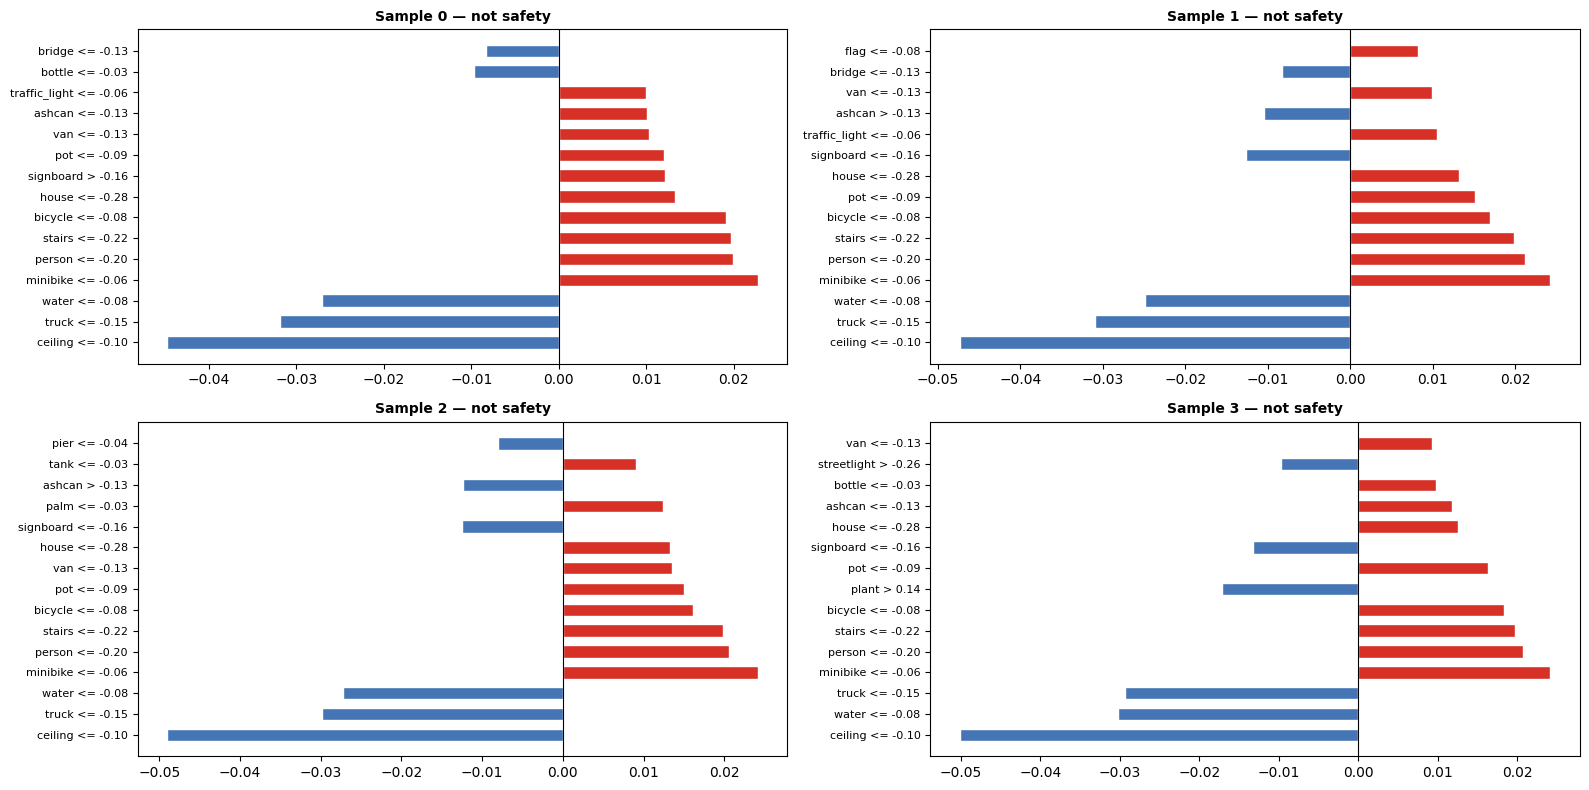

In [19]:
analyzer.plot_explanation(explanations, top_n_features=cfg.TOP_K_FEATURES)

In [20]:
explanation = analyzer.explain(X_test, sample_idx=2, labels_to_explain=len(label_map), num_features=len(feature_names))
explanation

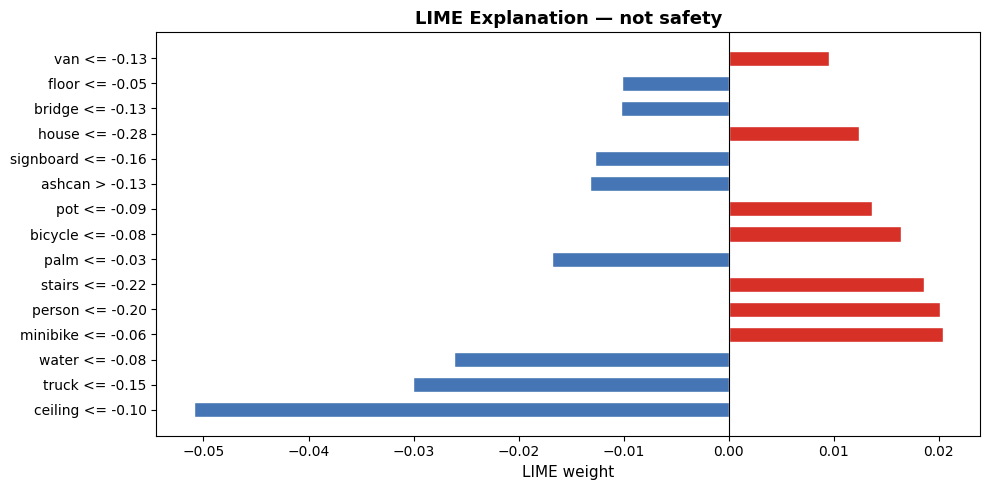

In [21]:
analyzer.plot_explanation(explanation, top_n_features=cfg.TOP_K_FEATURES)

In [22]:
lime_df = analyzer.get_lime_df(explanations)
lime_df

,sample_idx,feature,weight
0,0,ceiling <= -0.10,-0.044782
1,0,truck <= -0.15,-0.031847
2,0,water <= -0.08,-0.027119
3,0,minibike <= -0.06,0.022762
4,0,person <= -0.20,0.019868
...,...,...,...
255,3,sand <= -0.04,0.000028
256,3,tower <= 0.00,0.000000
257,3,skyscraper <= 0.00,0.000000
258,3,sculpture <= 0.00,0.000000


In [23]:
features_df = analyzer.get_feature_importance(explanations)
features_df

,feature,mean_abs_weight
0,ceiling,0.047837
1,truck,0.030484
2,water,0.027357
3,minibike,0.023850
4,person,0.020582
...,...,...
68,0.07 < road,0.000131
69,skyscraper,0.000000
70,base,0.000000
71,tower,0.000000


In [24]:
analyzer.top_features(explanations, top_n_features=cfg.TOP_K_FEATURES)


Top 15 features by mean |LIME weight|:
      feature  mean_abs_weight
      ceiling         0.047837
        truck         0.030484
        water         0.027357
     minibike         0.023850
       person         0.020582
       stairs         0.019773
      bicycle         0.017624
          pot         0.014638
        house         0.013059
    signboard         0.012638
       ashcan         0.011171
          van         0.010747
        plant         0.009993
traffic_light         0.009088
       bridge         0.007917


,feature,mean_abs_weight
0,ceiling,0.047837
1,truck,0.030484
2,water,0.027357
3,minibike,0.023850
4,person,0.020582
5,stairs,0.019773
6,bicycle,0.017624
7,pot,0.014638
8,house,0.013059
9,signboard,0.012638


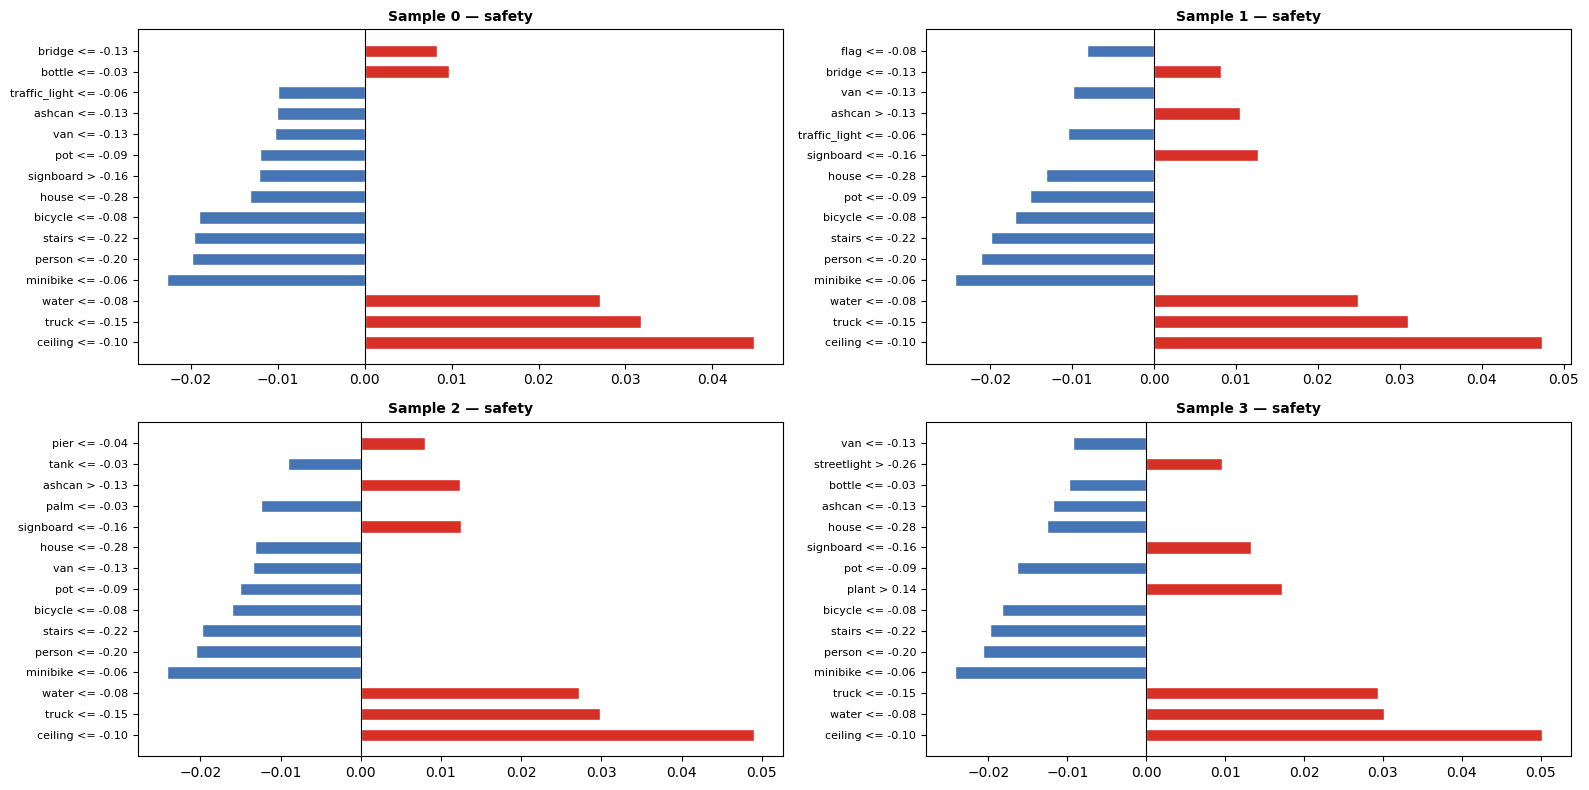

In [25]:
analyzer.plot_multiple(explanations, label=1, top_n_features=cfg.TOP_K_FEATURES)

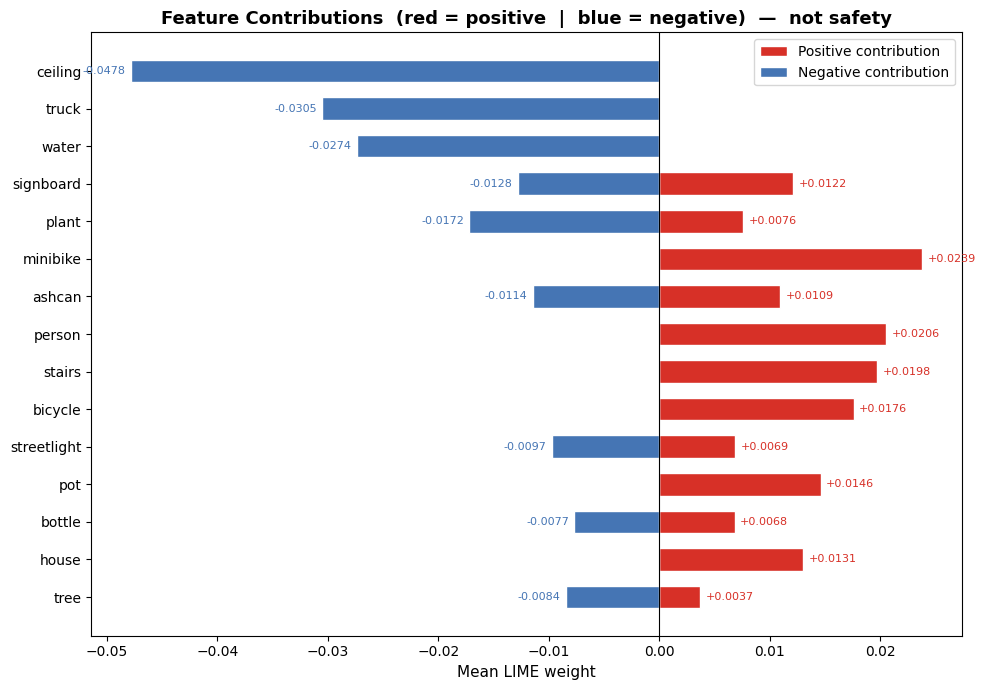

In [26]:
analyzer.contribution_plot(explanations, top_n_features=cfg.TOP_K_FEATURES)


Top 15 features by mean |LIME weight|:
      feature  mean_abs_weight
      ceiling         0.047837
        truck         0.030484
        water         0.027357
     minibike         0.023850
       person         0.020582
       stairs         0.019773
      bicycle         0.017624
          pot         0.014638
        house         0.013059
    signboard         0.012638
       ashcan         0.011171
          van         0.010747
        plant         0.009993
traffic_light         0.009088
       bridge         0.007917


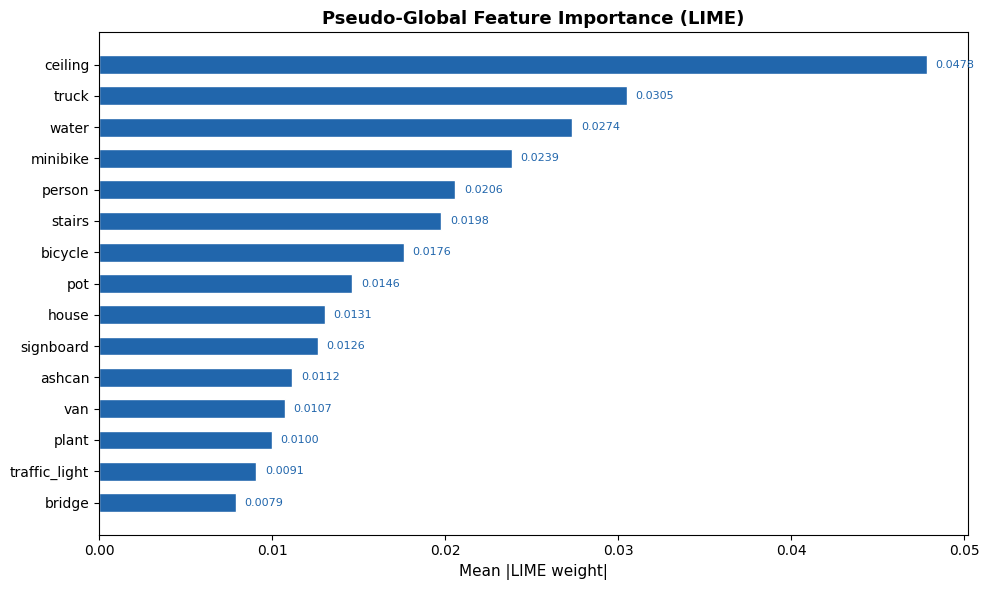

In [27]:
analyzer.feature_importance_plot(explanations, top_n_features=cfg.TOP_K_FEATURES)